In [1]:
#New version of numpy is there, using the upgraded one
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random
import matplotlib.pyplot as plt
%matplotlib inline

from itertools import cycle

from math import ceil

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

warnings.filterwarnings('ignore')

#the sales training data has more than 1900 columns
pd.set_option('max_columns', 100)
#These are used for better plotting, check them later or ask about them
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [2]:
input_dir = '/home/aviral/Desktop/retail/m5-forecasting-accuracy/'

#CHECK AGAIN HOW THIS IS WORKING, IS IT ZIP MECHANISM OR SOMETHING ELSE
#Standard function, copied from stack exchange
def reduce_mem_usage(df, verbose=False):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics: 
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
def read_data(input_dir):
    sell_prices_df = pd.read_csv(input_dir+'sell_prices.csv')
    sell_prices_df = reduce_mem_usage(df=sell_prices_df, verbose=True)
    print('The shape of sell prices is ', sell_prices_df.shape)
    
    sales_train_validation_df = pd.read_csv(input_dir+'sales_train_validation.csv')
    sales_train_validation_df = reduce_mem_usage(df=sales_train_validation_df, verbose=True)
    print('The shape of sales data is ', sales_train_validation_df.shape)
    
    calendar_df = pd.read_csv(input_dir+'calendar.csv')
    calendar_df = reduce_mem_usage(df=calendar_df, verbose=True)
    print('The shape of the calendar is ', calendar_df.shape)
    
    return sell_prices_df, sales_train_validation_df, calendar_df
    

In [4]:
t1 = time.time()
sell_df, sales_df, calendar = read_data(input_dir)
t2 = time.time()
print('Time taken for loading data is ', (t2-t1))
#!!!!!!!!!!!
#Sell prices is displaying and loading here, but in the end when I do operations on it, it hangs

Mem. usage decreased to 130.48 Mb (37.5% reduction)
The shape of sell prices is  (6841121, 4)
Mem. usage decreased to 95.00 Mb (78.7% reduction)
The shape of sales data is  (30490, 1919)
Mem. usage decreased to  0.12 Mb (41.9% reduction)
The shape of the calendar is  (1969, 14)
Time taken for loading data is  86.99620866775513


In [5]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [6]:
sales_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,...,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,1,3,0,0,0,1,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,2,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,1,0,...,5,3,1,0,0,0,1,2,3,0,1,3,4,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,2,1,1,0,3,1,1,2,1,1,0,3,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


In [7]:
#CHECK THE MISSING WEEKS' DATA
sell_df.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125
2,CA_1,HOBBIES_1_001,11327,8.257812
3,CA_1,HOBBIES_1_001,11328,8.257812
4,CA_1,HOBBIES_1_001,11329,8.257812


In [8]:
import datetime
#Create a dates list, this will be used in plotting later
date_index = calendar['date']
#Even though the calendar has 1969 dates, the sales data is available for only 1913 days
#The rest of it might be for validation and testing, CHECK!!!
dates = date_index[0:1819]
dates_list = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]

In [9]:
#This is the aggregated per category and per store
data = pd.DataFrame(sales_df.groupby(by = ['cat_id', 'dept_id', 'item_id', 'store_id']).sum())
data.head(n=15)

d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  \
cat_id dept_id item_id     store_id                                           
FOODS  FOODS_1 FOODS_1_001 CA_1        3    0    0    1    4    2    0    2   
                           CA_2        2    0    0    0    1    0    8    0   
                           CA_3        1    2    1    1    1    2    0    1   
                           CA_4        0    1    1    1    1    1    0    0   
                           TX_1        0    1    1    0    0    0    0    0   
                           TX_2        0    0    1    2    0    4    0    0   
                           TX_3        0    0    0    0    0    0    0    0   
                           WI_1        0    2    0    1    0    5    0    0   
                           WI_2        0    0    0    0    0    1    2    1   
                           WI_3        0    0    0    0    0    3    0    0   
               FOODS_1_002 CA_1        0    1    0    1    1    1    0    0   
                           CA_2        2    1    1    0    2    2    0    1   
                           CA_3        1    0    1    2    0    0    0    1   
                           CA_4        0    1    2    1    0    0    0    0   
                           TX_1        0    0    0    0    0    0    0    0   

                                     d_9  d_10  d_11  d_12  d_13  d_14  d_15  \
cat_id dept_id item_id     store_id                                            
FOODS  FOODS_1 FOODS_1_001 CA_1        0     0     0     0     3     1     3   
                           CA_2        4     1     2     1     1     3     4   
                           CA_3        1     1     0     0     3     3     2   
                           CA_4        0     0     0     0     1     2     1   
                           TX_1        2     1     0     0     0     1     0   
                           TX_2        2     2     0     1     2     0     0   
                           TX_3        0     0     4     1     0     0     0   
                           WI_1        1     1     0     0     1     0     2   
                           WI_2        1     1     0     0     0     1     2   
                           WI_3        0     3     0     2     1     4     2   
               FOODS_1_002 CA_1        0     0     1     1     0     2     0   
                           CA_2        0     0     1     0     0     0     5   
                           CA_3        1     0     1     0     0     0     1   
                           CA_4        0     1     0     1     0     0     0   
                           TX_1        0     0     0     1     0     2     1   

                                     d_16  d_17  d_18  d_19  d_20  d_21  d_22  \
cat_id dept_id item_id     store_id                                             
FOODS  FOODS_1 FOODS_1_001 CA_1         0     2     1     2     0     2     1   
                           CA_2         1     2     2     2     0     1     1   
                           CA_3         7     1     2     4     0     1     1   
                           CA_4         0     1     0     0     1     0     2   
                           TX_1         0     0     0     0     0     0     0   
                           TX_2         4     4     1     0     1     2     0   
                           TX_3         0     0     2     1     1     0     1   
                           WI_1         0     0     1     2     0     7     0   
                           WI_2         0     1     1     1     1     4     1   
                           WI_3         6     0     0     0     3     0     2   
               FOODS_1_002 CA_1         1     0     0     0     0     0     0   
                           CA_2         3     0     0     0     0     0     3   
                           CA_3         0     0     0     0     0     1     0   
                           CA_4         0     0     0     1     0     0     0   
                           TX_1     

In [10]:
#The complete sales for the 6 year time period of each item in each of the stores

sales = pd.DataFrame(data.sum(axis = 1))
sales.rename(columns = {0:'sales'},inplace=True)
sales.head(15)

sales
cat_id dept_id item_id     store_id       
FOODS  FOODS_1 FOODS_1_001 CA_1       1503
                           CA_2       2214
                           CA_3       2302
                           CA_4        688
                           TX_1       1119
                           TX_2       1112
                           TX_3        785
                           WI_1       1086
                           WI_2        875
                           WI_3        563
               FOODS_1_002 CA_1        914
                           CA_2       1154
                           CA_3        603
                           CA_4        640
                           TX_1        323

In [11]:
#Same procedure as above, but now the tables are store-wise instead of item-wise
stores_df = pd.DataFrame(sales_df.groupby(by = ['store_id', 'cat_id']).sum())

stores = pd.DataFrame(stores_df.sum(axis=1))
stores.rename(columns = {0:'Total sales'}, inplace=True)
stores

Total sales
store_id cat_id                
CA_1     FOODS        5380828.0
         HOBBIES       876678.0
         HOUSEHOLD    1440710.0
CA_2     FOODS        3480259.0
         HOBBIES       637803.0
         HOUSEHOLD    1567413.0
CA_3     FOODS        7515790.0
         HOBBIES       960947.0
         HOUSEHOLD    2711443.0
CA_4     FOODS        2819425.0
         HOBBIES       564455.0
         HOUSEHOLD     719796.0
TX_1     FOODS        3778209.0
         HOBBIES       429084.0
         HOUSEHOLD    1387999.0
TX_2     FOODS        5015124.0
         HOBBIES       635997.0
         HOUSEHOLD    1563263.0
TX_3     FOODS        4163088.0
         HOBBIES       527258.0
         HOUSEHOLD    1398984.0
WI_1     FOODS        3438352.0
         HOBBIES       655696.0
         HOUSEHOLD    1055014.0
WI_2     FOODS        4768184.0
         HOBBIES       370214.0
         HOUSEHOLD    1405614.0
WI_3     FOODS        4730680.0
         HOBBIES       466668.0
         HOUSEHOLD    1230434.0

Text(0.5, 1.0, 'Store-wise sales across the categories')

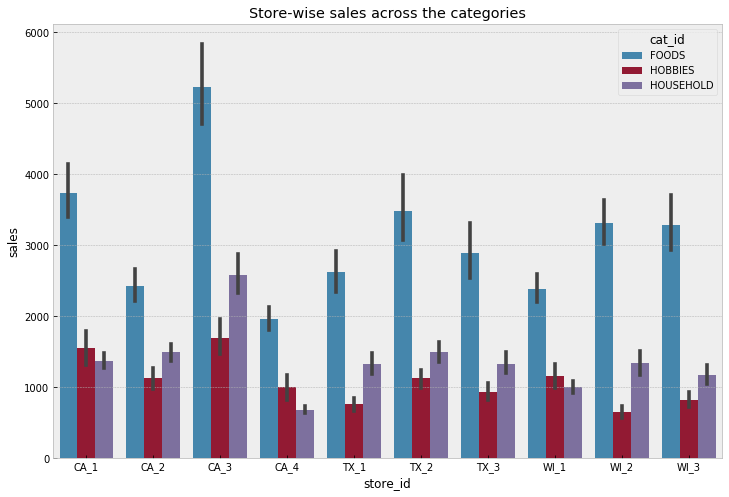

In [12]:
import seaborn as sns

#The reset_index() function is used frequently but its use is not clear
sale = sales.copy().reset_index()


plt.figure(figsize=(12,8))
sns.barplot(x= sale['store_id'],y=sale['sales'],hue=sale['cat_id'])
plt.title('Store-wise sales across the categories')

#Ask what the middle grey lines in each bar plot represent

In [13]:
calendar_orig = calendar.copy()
calendar = calendar[0:1913]
#While merging and plotting, only the first 1913 days have all available data
calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,2016-04-20,11612,Wednesday,5,4,2016,d_1909,NaN,NaN,NaN,NaN,0,0,0
1909,2016-04-21,11612,Thursday,6,4,2016,d_1910,NaN,NaN,NaN,NaN,0,0,0
1910,2016-04-22,11612,Friday,7,4,2016,d_1911,NaN,NaN,NaN,NaN,0,0,0
1911,2016-04-23,11613,Saturday,1,4,2016,d_1912,NaN,NaN,NaN,NaN,0,0,0


In [14]:
#Unable to merge dataframes, trying an alternate method; kind of a hack

#food = pd.DataFrame(data.xs('FOODS').sum(axis = 0))[0].tolist()
#hobbies = pd.DataFrame(data.xs('HOBBIES').sum(axis = 0))[0].tolist()
#house = pd.DataFrame(data.xs('HOUSEHOLD').sum(axis = 0))[0].tolist()

#calendar['food'] = food
#calendar['hobbies'] = hobbies
#calendar['households'] = house
#calendar

In [15]:
#MERGING THE SALES DATA WITH THE CALENDAR

food = pd.DataFrame(data.xs('FOODS').sum(axis = 0))
hobbies = pd.DataFrame(data.xs('HOBBIES').sum(axis = 0))
house = pd.DataFrame(data.xs('HOUSEHOLD').sum(axis = 0))

calendar = pd.merge(calendar,food,how = 'left',left_on=calendar['d'],right_on = food.index)
del calendar['key_0']
calendar.rename(columns = {0:'food'},inplace = True)
calendar = pd.merge(calendar,hobbies,how = 'left',left_on=calendar['d'],right_on = hobbies.index)
del calendar['key_0']
calendar.rename(columns = {0:'hobby'},inplace = True)
calendar = pd.merge(calendar,house,how = 'left',left_on=calendar['d'],right_on = house.index)
del calendar['key_0']
calendar.rename(columns = {0:'house'},inplace = True)

calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,food,hobby,house
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,23178,3764,5689
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,22758,3357,5634
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,17174,2682,3927
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,18878,2669,3865
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,14603,1814,2729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,2016-04-20,11612,Wednesday,5,4,2016,d_1909,NaN,NaN,NaN,NaN,0,0,0,23632,3472,8239
1909,2016-04-21,11612,Thursday,6,4,2016,d_1910,NaN,NaN,NaN,NaN,0,0,0,23317,3353,8363
1910,2016-04-22,11612,Friday,7,4,2016,d_1911,NaN,NaN,NaN,NaN,0,0,0,26704,4085,9728
1911,2016-04-23,11613,Saturday,1,4,2016,d_1912,NaN,NaN,NaN,NaN,0,0,0,31927,4787,12248


In [16]:
# Taking daily Sales data for each each category from each store and merging with calender data.
#Dont run this cell twice, it creates issues later

l1 = ['FOODS','HOBBIES','HOUSEHOLD']
l2 = list(sales_df['store_id'].unique())
for cat in l1:
    for store in l2:
        tmp = pd.DataFrame(data.xs(cat).xs(store,level = 2 ).sum(axis = 0))
        tmp.reset_index(inplace = True)
        tmp.rename(columns = {0:(cat+'_'+store).lower()},inplace = True)
        calendar = pd.concat([calendar,tmp[(cat+'_'+store).lower()]],axis = 1)
        
calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,food,hobby,house,foods_ca_1,foods_ca_2,foods_ca_3,foods_ca_4,foods_tx_1,foods_tx_2,foods_tx_3,foods_wi_1,foods_wi_2,foods_wi_3,hobbies_ca_1,hobbies_ca_2,hobbies_ca_3,hobbies_ca_4,hobbies_tx_1,hobbies_tx_2,hobbies_tx_3,hobbies_wi_1,hobbies_wi_2,hobbies_wi_3,household_ca_1,household_ca_2,household_ca_3,household_ca_4,household_tx_1,household_tx_2,household_tx_3,household_wi_1,household_wi_2,household_wi_3
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,23178,3764,5689,3239,2193,3446,1223,1781,2788,2284,1581,1615,3028,556,538,550,158,251,385,243,615,190,278,542,763,743,244,524,679,503,508,451,732
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,22758,3357,5634,3137,1921,3535,1269,1903,2870,2257,1327,1433,3106,498,397,430,236,264,359,247,443,127,356,520,728,862,272,520,708,502,424,362,736
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,17174,2682,3927,2008,1289,2701,946,1377,2082,1665,977,1586,2543,415,368,438,251,107,229,190,323,113,248,393,464,646,189,338,420,370,262,319,526
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,18878,2669,3865,2258,1540,3064,1002,1643,2180,1647,935,2013,2596,392,350,424,239,248,359,202,137,124,194,401,434,744,199,367,415,320,179,385,421
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,14603,1814,2729,2032,1278,2761,1107,1329,1890,1383,2,967,1854,268,296,364,253,102,257,142,0,58,74,330,368,692,176,263,345,201,0,150,204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,2016-04-20,11612,Wednesday,5,4,2016,d_1909,NaN,NaN,NaN,NaN,0,0,0,23632,3472,8239,2490,2506,3286,1581,1834,2196,2212,2290,3005,2232,363,344,534,405,273,373,334,326,276,244,869,841,1415,514,794,815,769,626,913,683
1909,2016-04-21,11612,Thursday,6,4,2016,d_1910,NaN,NaN,NaN,NaN,0,0,0,23317,3353,8363,2533,2261,3056,1629,1777,2239,2151,2285,3078,2308,410,271,540,369,219,340,323,397,281,203,766,771,1422,460,780,867,906,642,1034,715
1910,2016-04-22,11612,Friday,7,4,2016,d_1911,NaN,NaN,NaN,NaN,0,0,0,26704,4085,9728,2960,2871,3409,1751,1922,2547,2370,2790,3419,2665,527,485,598,405,271,388,397,415,303,296,900,1101,1616,472,829,967,924,786,1266,867
1911,2016-04-23,11613,Saturday,1,4,2016,d_1912,NaN,NaN,NaN,NaN,0,0,0,31927,4787,12248,3655,3760,4459,1971,2319,2930,2600,3242,3751,3240,670,542,765,390,289,436,497,503,282,413,1252,1582,2195,593,1092,1117,986,1027,1371,1033


In [17]:
#This is the function used for plotting monthly, weekly and yearly data.
#This still has to be changed and debugged but first the data has to be merged properly

grps = calendar.groupby(by=['year','month'])
def plot_trend(factor,subplots):
    if subplots == True:
        f, a = plt.subplots(3,2,figsize = (14,10))
        if type(factor) == list:
            for i,fact in enumerate(factor):
                check = grps.agg(fact=(fact,'sum'))
                check.rename(columns = {'fact':factor[i]},inplace=True)
                check.xs(2011).plot(ax=a[0,0])
                check.xs(2012).plot(ax=a[0,1])
                check.xs(2013).plot(ax=a[1,0])
                check.xs(2014).plot(ax=a[1,1])
                check.xs(2015).plot(ax=a[2,0])
                check.xs(2016).plot(ax=a[2,1])
                
        else:
            check = grps.agg({factor:'sum'})
            check.xs(2011).plot(ax=a[0,0])
            check.xs(2012).plot(ax=a[0,1])
            check.xs(2013).plot(ax=a[1,0])
            check.xs(2014).plot(ax=a[1,1])
            check.xs(2015).plot(ax=a[2,0])
            check.xs(2016).plot(ax=a[2,1])
        
        a[0,0].title.set_text('2011')
        a[0,1].title.set_text('2012')
        a[1,0].title.set_text('2013')
        a[1,1].title.set_text('2014')
        a[2,0].title.set_text('2015')
        a[2,1].title.set_text('2016')
        
        f.tight_layout()
        f.suptitle('Monthly Sales Trends')
    else:
        fig,ax = plt.subplots(figsize = (20,5))
        for fact in factor:
            calendar.set_index('date')[fact].rolling(30).mean().plot(label = fact)
            plt.legend()
            fig.suptitle('30 Day Moving Average')

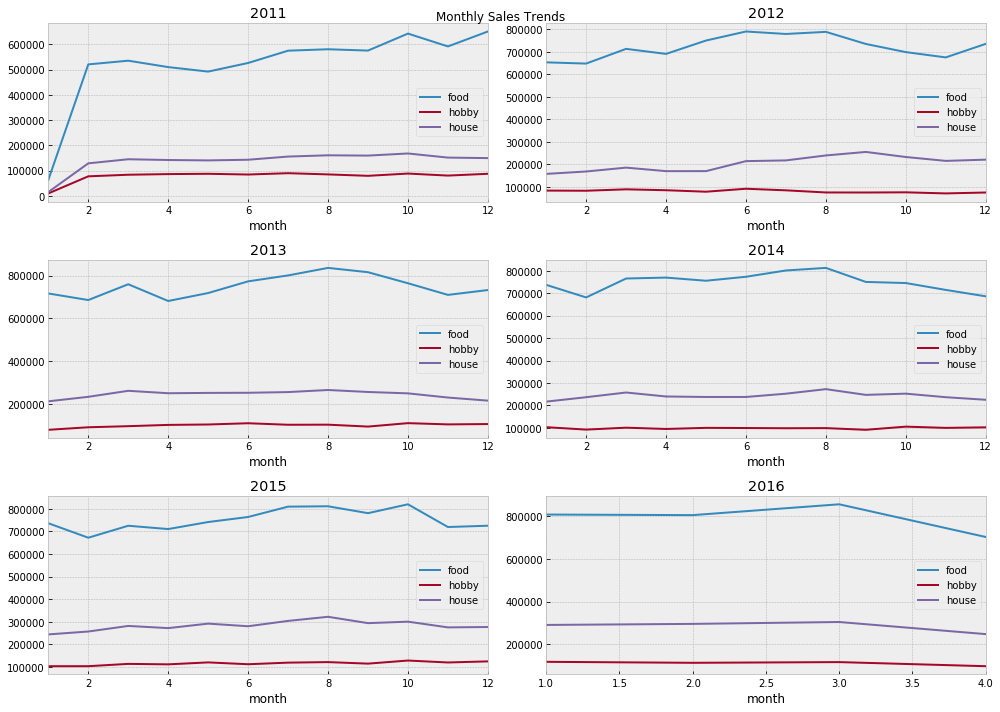

In [18]:
plot_trend(['food','hobby','house'],subplots = True)

In [19]:
#The initial part of the 2011 graph is not an outlier, just that there is data only for few days that month

In [20]:
#Using minscaler here, otherwise the high sales of food overshadows all other sales and makes graphs harder to read

cols = calendar.iloc[:,14:].columns
scaled_df = pd.DataFrame(MinMaxScaler().fit_transform( calendar.iloc[:,15:]))
for i in range(0,len(cols)):
    scaled_df.rename(columns = {i:cols[i]},inplace = True)
cln_scaled = calendar.iloc[:,:14]
cln_scaled = pd.concat([calendar.iloc[:,:14],scaled_df],axis = 1)

In [21]:
new_grps = cln_scaled.groupby(by=['year','month'])
def plot_trend_scaled(factor,subplots):
    if subplots == True:
        f, a = plt.subplots(6,1,figsize = (14,36))
        if type(factor) == list:
            for i,fact in enumerate(factor):
                check = new_grps.agg(fact=(fact,'sum'))
                check.rename(columns = {'fact':factor[i]},inplace=True)
                check.xs(2011).plot(ax=a[0])
                check.xs(2012).plot(ax=a[1])
                check.xs(2013).plot(ax=a[2])
                check.xs(2014).plot(ax=a[3])
                check.xs(2015).plot(ax=a[4])
                check.xs(2016).plot(ax=a[5])
                
        else:
            check = new_grps.agg({factor:'sum'})
            check.xs(2011).plot(ax=a[0])
            check.xs(2012).plot(ax=a[1])
            check.xs(2013).plot(ax=a[2])
            check.xs(2014).plot(ax=a[3])
            check.xs(2015).plot(ax=a[4])
            check.xs(2016).plot(ax=a[5])
        a[0].title.set_text('2011')
        a[1].title.set_text('2012')
        a[2].title.set_text('2013')
        a[3].title.set_text('2014')
        a[4].title.set_text('2015')
        a[5].title.set_text('2016')
        f.tight_layout()
        f.suptitle('Monthly Sales Trends')
    else:
        fig,ax = plt.subplots(figsize = (20,5))
        for fact in factor:
            cln_scaled.set_index('date')[fact].rolling(30).mean().plot(label = fact)
            plt.legend()
            fig.suptitle('30 Day Moving Average')

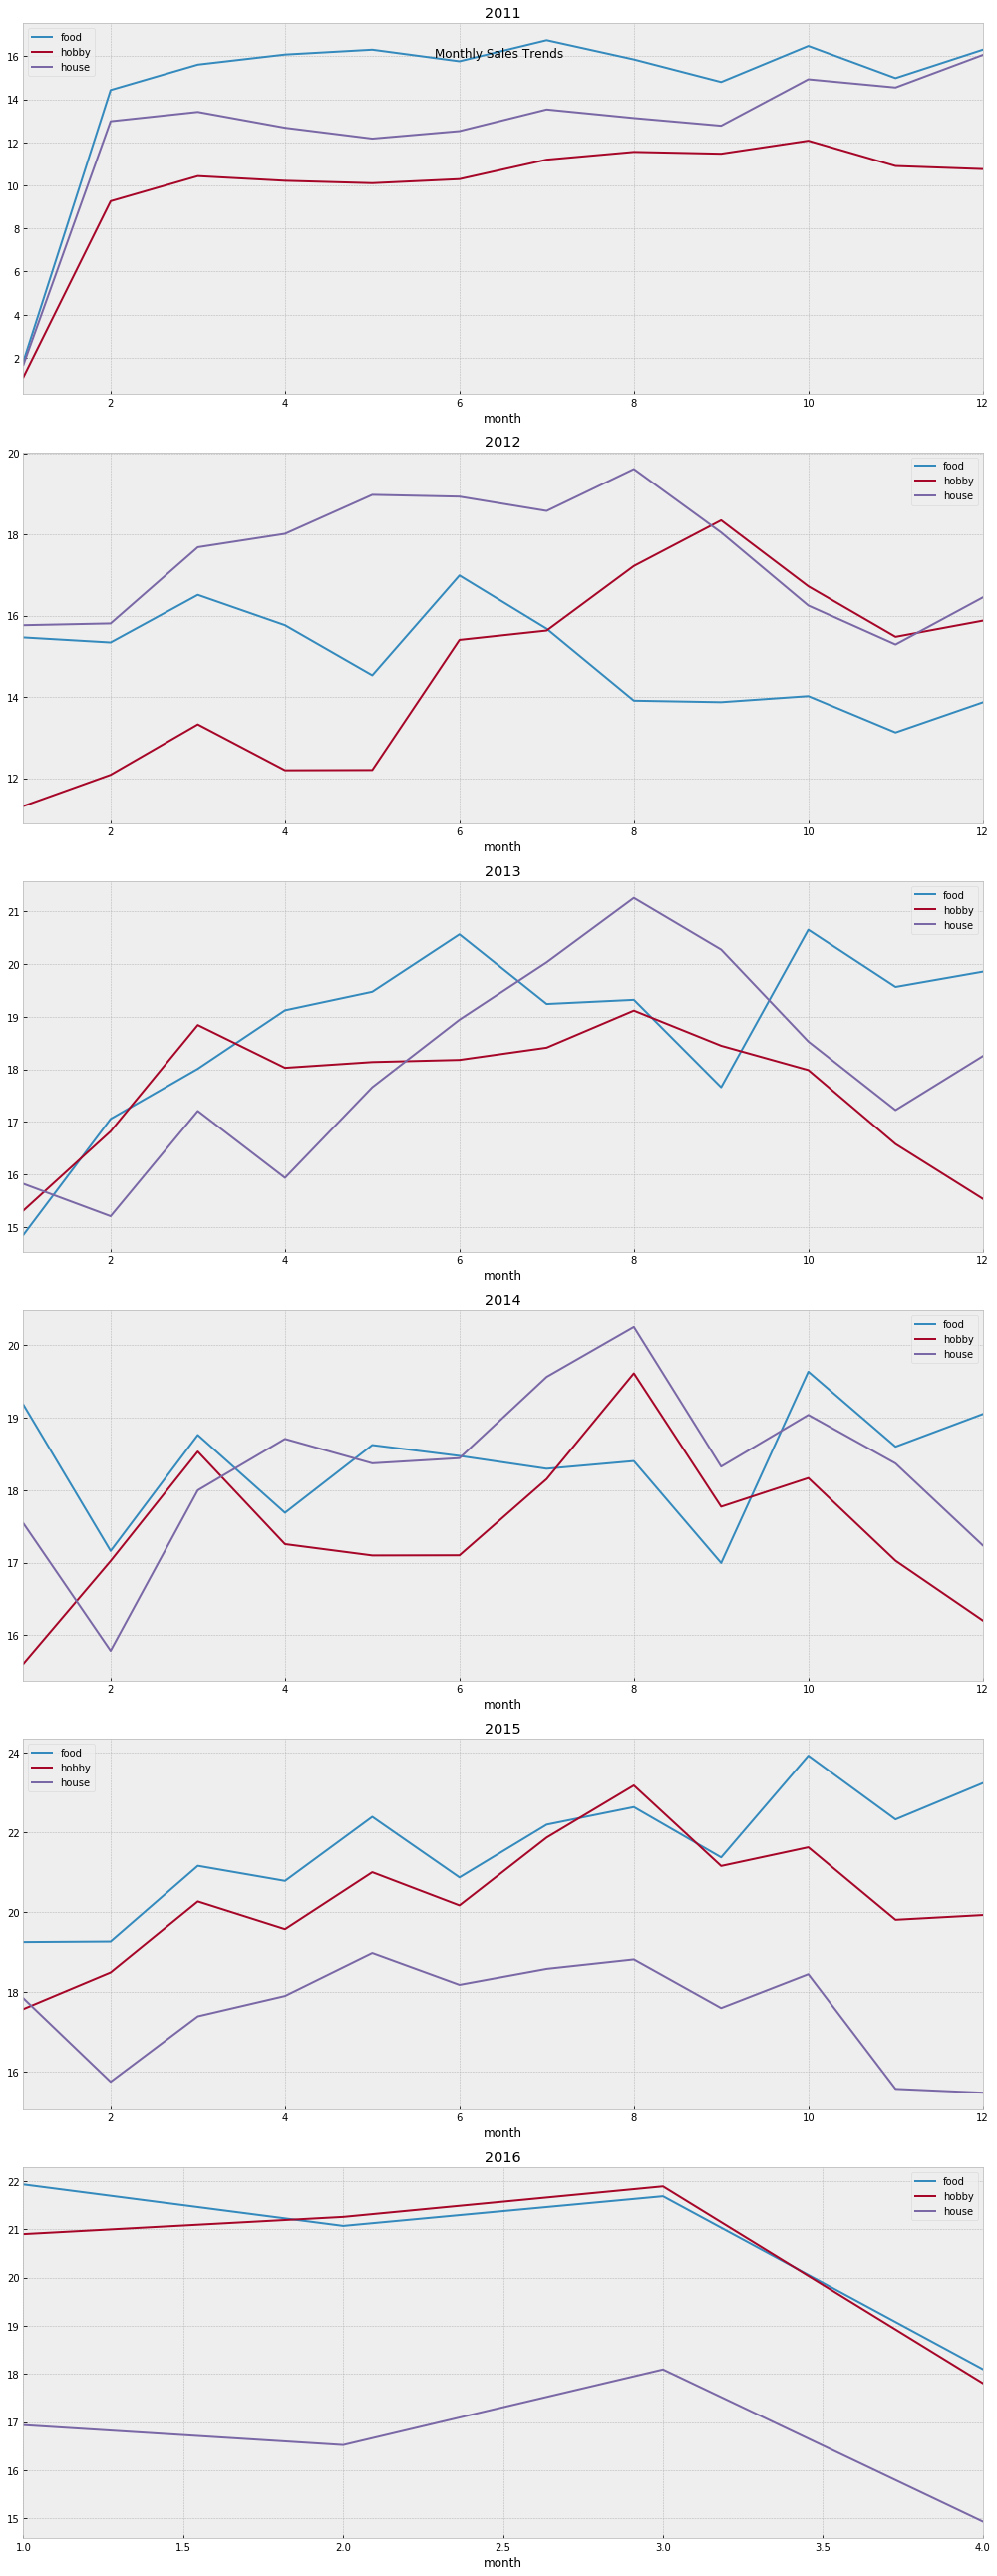

In [22]:
plot_trend_scaled(['food','hobby','house'],subplots = True)

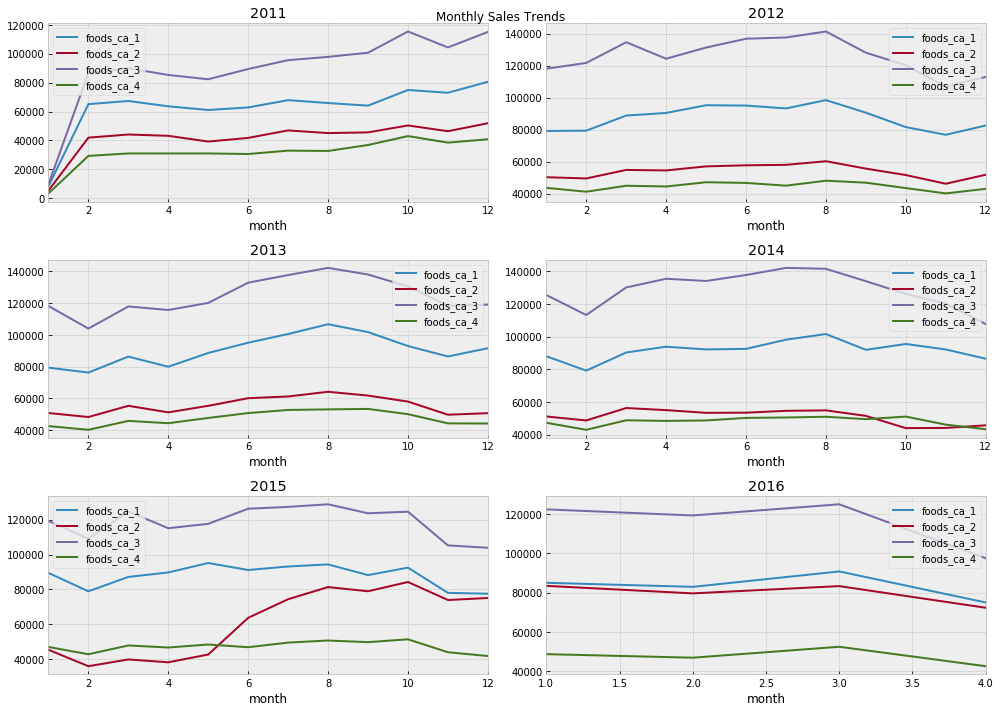

In [23]:
plot_trend(['foods_ca_1','foods_ca_2','foods_ca_3','foods_ca_4'],subplots = True)

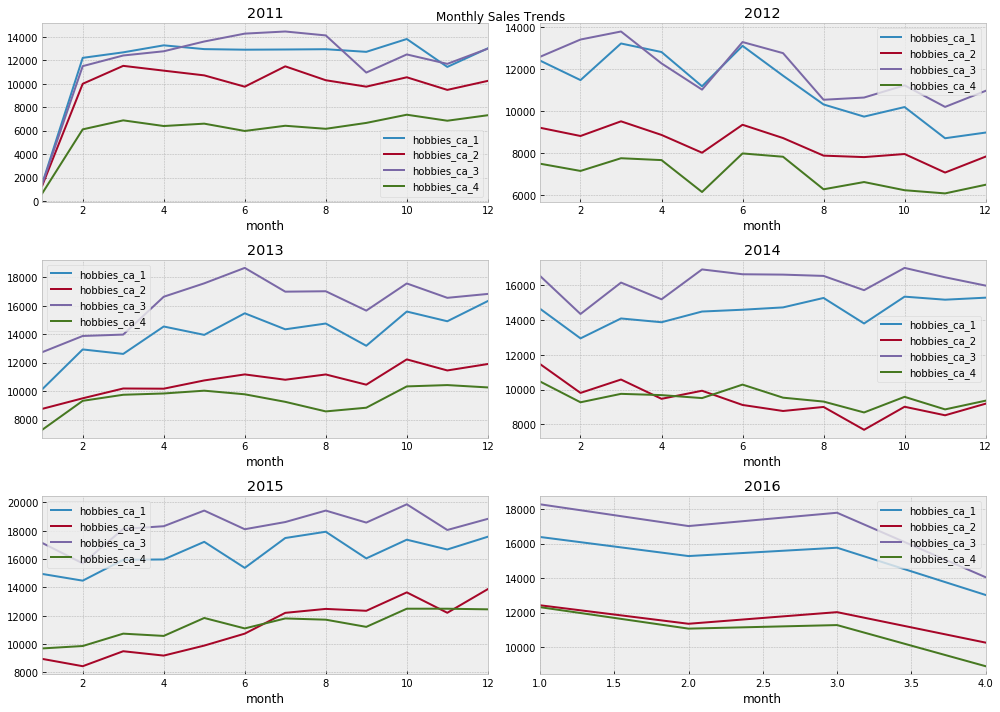

In [24]:
#These two functions have a lot of flexibiliity, change the list to get anything out of the 47 available columns
#Also you can subplots false to get annual data, like the financial data
# MOVING AVERAGES can be computed this way
# few examples are available below

plot_trend(['hobbies_ca_1','hobbies_ca_2','hobbies_ca_3','hobbies_ca_4'],subplots = True)

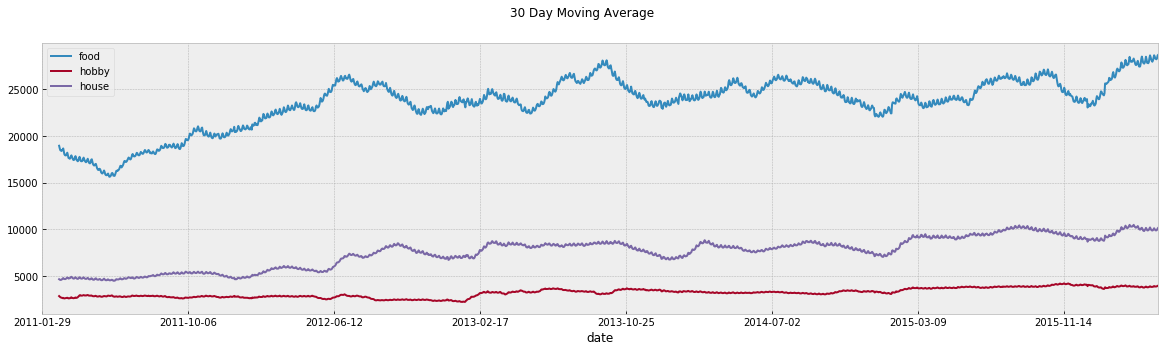

In [25]:
plot_trend(['food','hobby', 'house'], subplots=False)

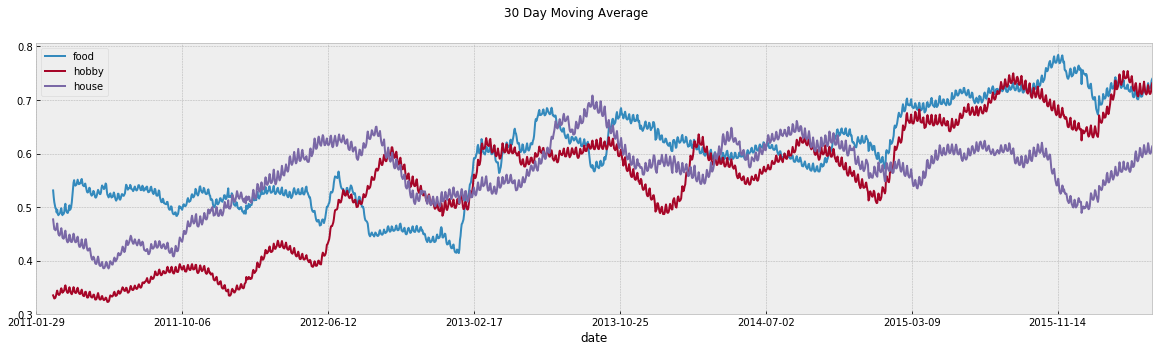

In [26]:
plot_trend_scaled(['food','hobby', 'house'], subplots=False)

In [27]:
# The ideas and codes after this are somewhat redundant, but for analysis for different things and time scales

In [28]:
groups = calendar.groupby(by=['year','month','date']).sum()
def monthly_sale(month,item,years):
    tmp = groups.xs(month,level=1)[item].unstack(level=0)
    tmp.reset_index(inplace=True)
    #check if there is an alternate way to handle the above error
    tmp['date'] = pd.to_datetime(tmp['date'], errors='coerce')
    tmp['days'] = tmp['date'].dt.day
    fig,ax = plt.subplots(figsize = (12,8))
    for year in years:
        plt.plot(tmp['days'],tmp[year],axes = ax,label=year)
        plt.legend()
        
groups

wm_yr_wk  wday  snap_CA  snap_TX  snap_WI   food  \
year month date                                                           
2011 1     2011-01-29     11101     1        0        0        0  23178   
           2011-01-30     11101     2        0        0        0  22758   
           2011-01-31     11101     3        0        0        0  17174   
     2     2011-02-01     11101     4        1        1        0  18878   
           2011-02-02     11101     5        1        0        1  14603   
...                         ...   ...      ...      ...      ...    ...   
2016 4     2016-04-20     11612     5        0        0        0  23632   
           2016-04-21     11612     6        0        0        0  23317   
           2016-04-22     11612     7        0        0        0  26704   
           2016-04-23     11613     1        0        0        0  31927   
           2016-04-24     11613     2        0        0        0  32654   

                       hobby  house  foods_ca_1  foods_ca_2  foods_ca_3  \
year month date                                                           
2011 1     2011-01-29   3764   5689        3239        2193        3446   
           2011-01-30   3357   5634        3137        1921        3535   
           2011-01-31   2682   3927        2008        1289        2701   
     2     2011-02-01   2669   3865        2258        1540        3064   
           2011-02-02   1814   2729        2032        1278        2761   
...                      ...    ...         ...         ...         ...   
2016 4     2016-04-20   3472   8239        2490        2506        3286   
           2016-04-21   3353   8363        2533        2261        3056   
           2016-04-22   4085   9728        2960        2871        3409   
           2016-04-23   4787  12248        3655        3760        4459   
           2016-04-24   4683  12458        4053        4012        4698   

                       foods_ca_4  foods_tx_1  foods_tx_2  foods_tx_3  \
year month date                                                         
2011 1     2011-01-29        1223        1781        2788        2284   
           2011-01-30        1269        1903        2870        2257   
           2011-01-31         946        1377        2082        1665   
     2     2011-02-01        1002        1643        2180        1647   
           2011-02-02        1107        1329        1890        1383   
...                           ...         ...         ...         ...   
2016 4     2016-04-20        1581        1834        2196        2212   
           2016-04-21        1629        1777        2239        2151   
           2016-04-22        1751        1922        2547        2370   
           2016-04-23        1971        2319        2930        2600   
           2016-04-24        2043        2491        2853        2421   

                       foods_wi_1  foods_wi_2  foods_wi_3  hobbies_ca_1  \
year month date                                                           
2011 1     2011-01-29        1581        1615        3028           556   
           2011-01-30        1327        1433        3106           498   
           2011-01-31         977        1586        2543           415   
     2     2011-02-01         935        2013        2596           392   
           2011-02-02           2         967        1854           268   
...                           ...         ...         ...           ...   
2016 4     2016-04-20        2290        3005        2232           363   
           2016-04-21        2285        3078        2308           410   
           2016-04-22        2790        3419        2665           527   
           2016-04-23        3242        3751        3240           670   
           2016-04-24        3317        3659        3107           714   

                       hobbies_ca_2  hobbies_ca_3  hobbies_ca_4  hobbies_tx_1  \
year month date                                                 

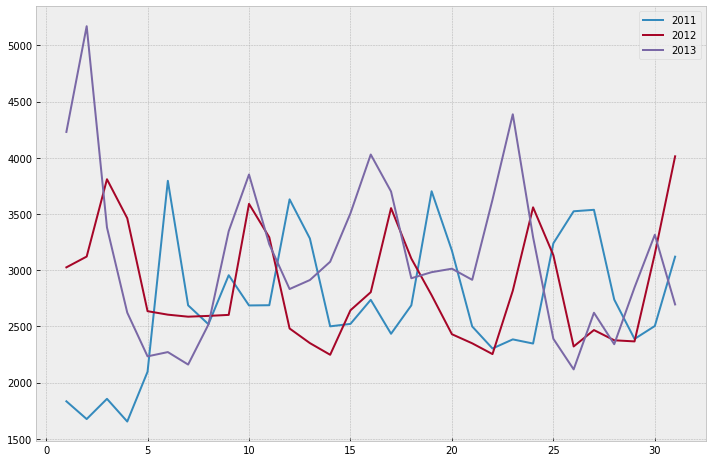

In [29]:
# the monthly comparison of march for all the six years
#monthly_sale(3,'hobby',[2011,2012,2013,2014,2015,2016])
#the above graph was all over the place
monthly_sale(3,'hobby',[2011,2012,2013])

In [30]:
calendar['date'] = pd.to_datetime(calendar['date'], errors='coerce')
calendar['days'] = calendar['date'].dt.day

In [31]:
tmpdf = calendar[~calendar['event_name_1'].isnull()]
def monthly_sale_event(month,item,year):
    tmp = groups.xs(month,level=1)[item].unstack(level=0)
    tmp.reset_index(inplace=True)
    tmp['date'] = pd.to_datetime(tmp['date'], errors='coerce')
    tmp['days'] = tmp['date'].dt.day
    fig,ax = plt.subplots(figsize = (12,8))
    tmpyr=tmpdf[tmpdf.year == year]
    l1=list(tmpyr[tmpyr.month==month]['days'])
    l2=list(tmpyr[tmpyr.month==month]['event_name_1'])
    print(l2)
    plt.plot(tmp['days'],tmp[year],axes = ax,label=year)
    plt.legend()
    axe = plt.gca()
    start,end = axe.get_ylim()[0],axe.get_ylim()[1]
    plt.vlines(l1,start,end,linestyles='--',color='r',alpha = 0.5)
    for i in range(0,len(l2)):
        plt.text(l1[i],end,l2[i])
    plt.show()

['Cinco De Mayo', "Mother's day", 'MemorialDay']


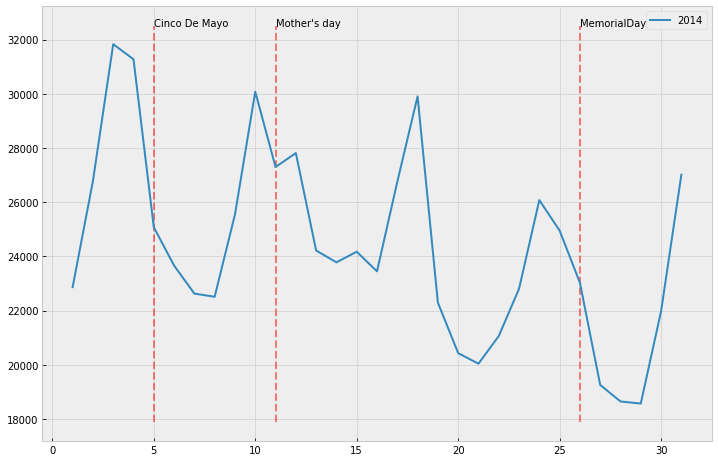

In [32]:
monthly_sale_event(5, 'food', 2014)

#This example does not show anything, but enter 12 and then see that near christmas
#There are distinct and specific changes in pattern

In [33]:
#This is again a very flexible function
#the first argument of time can be anything we want to plot on the x-axis; generally daily, wday, monthly, year
# the second argument can be any of the 33 available columns in calendar we want to plot
# the third argument tells the type of stats that we want to calculate

def sale_trend(time,item,cal_type):
    if time == 'daily':
        calendar.set_index('date')[item].plot(figsize = (15,5))
        calendar.set_index('date')[item].rolling(30).mean().plot(figsize = (15,5))
    else:
        if type(item) == list:
            fig,ax = plt.subplots(figsize = (15,5))
            for prod in item:
                if cal_type == 'sum':
                    cln.groupby(time)[item].sum().plot(figsize=(15,5),axes = ax)
                elif cal_type == 'mean':
                    cln.groupby(time)[item].mean().plot(figsize=(15,5),axes = ax)
        else:
            if cal_type == 'sum':
                calendar.groupby(time)[item].sum().plot(figsize=(15,5))
            elif cal_type == 'mean':
                calendar.groupby(time)[item].mean().plot(figsize=(15,5))
            elif cal_type == 'count':            #no of units of the category sold
                calendar.groupby(time)[item].count().plot(figsize=(15,5))
            #Ask Rahul what median in this particular data represents
            elif cal_type == 'median':
                calendar.groupby(time)[item].median().plot(figsize=(15,5))
            #Just keep adding more elif statements if more stats are required
            #There are at least 20 such statistics that are available that I found, others are complex


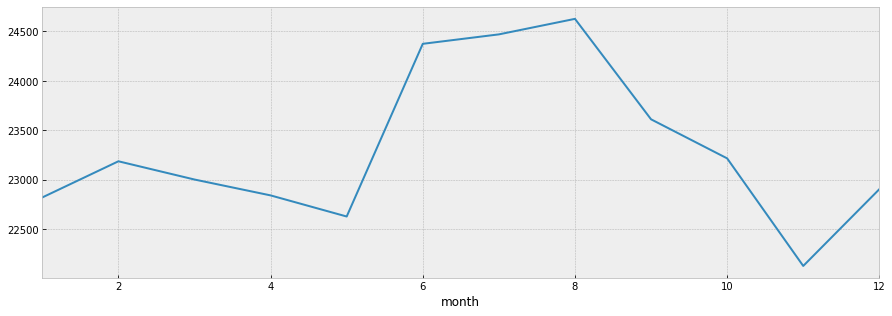

In [34]:
sale_trend('month','food','median')

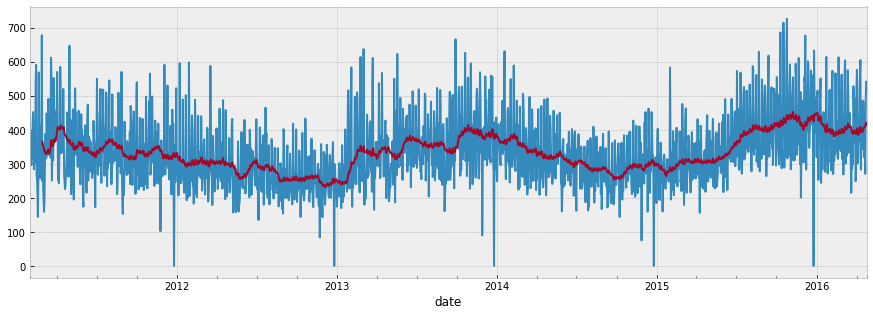

In [35]:
sale_trend('daily','hobbies_ca_2','sum')

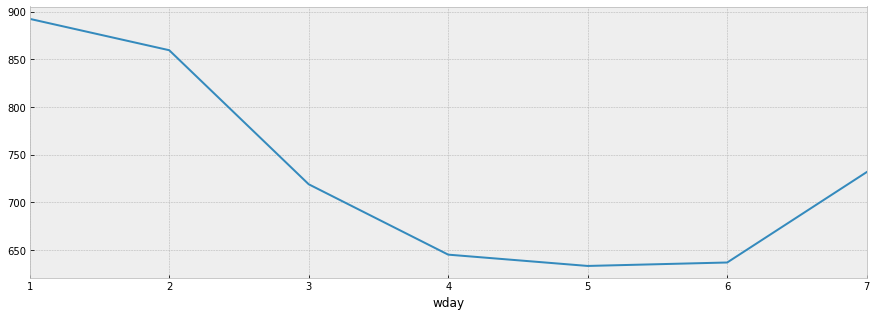

In [36]:
sale_trend('wday','household_tx_3','mean')

In [37]:
#Up until now all the analysis was in terms of sales patterns alone
# Now I am trying to add some graphs incorporating the price relations as well

In [39]:
#The prices are weekly, ask Rahul why they start from 11325 instead of 11101
t1 = time.time()
sell_df = pd.merge(sell_df, sales_df[['id', 'item_id', 'cat_id']], how='left', on='item_id')
t2 = time.time()
print('Time taken for merging is  ', (t2-t1))
prices

MemoryError: Unable to allocate 5.10 GiB for an array with shape (684112100,) and data type int64